# TinyGPT

**Author: Abraham R.**

The following notebook is an example of a really tiny GPT based model called TinyGPT.
You'll review the GPT architecture (transformer decoder) and implement the following tasks:

## TinyGPT Architecture

Tailored for the [NLP-II course](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-LLMIAG) as we deal with architectures and theory, this model consists of a **Mixture of Experts GPT**, equivalent to models like:
- DeepSeek
- Mistral

## Tasks

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

## Architecture:
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

## What to expect?

- You'll manage to understand a depth implementation of a GPT model.
- Implement a MoE Layer to create a state-of-the art GPT model.
- Explore decoding algorithms for text generation.


### NOTE

Tokenization is out of scope, we'll use a simple yet ineffective character-based tokenizer.


In [1]:
import torch
# 1) Desactiva el modo max_autotune_gemm
try:
    import torch._inductor.config as _inductor_config
    _inductor_config.max_autotune_gemm = False
except ImportError:
    pass
# 2) Activa TensorFloat‑32 (TF32) en operaciones matmul para mejor rendimiento (Ada)
torch.set_float32_matmul_precision('high')
# Opcionalmente:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

import logging
logging.getLogger("tornado.general").setLevel(logging.ERROR)
logging.getLogger("zmq.eventloop.zmqstream").setLevel(logging.ERROR)

In [2]:
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer, EarlyStopping
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import time
import math

In [3]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="./runs/experiment1")
writer_moe = SummaryWriter(log_dir="./runs/experiment2")

In [4]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

def plot_tensorboard_metrics (log_dir):
    event_files = [
        os.path.join(log_dir, f)
        for f in os.listdir(log_dir)
        if f.startswith("events.out.tfevents")
    ]
    assert event_files, f"No encontré events files en {log_dir}"
    event_path = sorted(event_files)[-1]
    ea = event_accumulator.EventAccumulator(
        event_path,
        size_guidance={event_accumulator.SCALARS: 0,}
    )
    ea.Reload()

    tag1 = "Loss/train"
    tag2 = "Loss/val"
    tag3 = "LR"

    def extract(tag):
        evts  = ea.Scalars(tag)
        steps = [e.step for e in evts]
        vals  = [e.value for e in evts]
        return steps, vals

    s1, v1 = extract(tag1)
    s2, v2 = extract(tag2)
    s3, v3 = extract(tag3)

    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    axs[0].plot(s1, v1, marker="o"); axs[0].set_title(tag1)
    axs[0].set_xlabel("Step"); axs[0].set_ylabel("Value"); axs[0].grid(True)

    axs[1].plot(s2, v2, marker="s"); axs[1].set_title(tag2)
    axs[1].set_xlabel("Step");                     axs[1].grid(True)

    axs[2].plot(s3, v3, marker="^"); axs[2].set_title(tag3)
    axs[2].set_xlabel("Step");                     axs[2].grid(True)

    plt.tight_layout()
    plt.show()

## Downloading Dataset

In [ ]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
full_text = response.text

print(full_text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [6]:
FULL = True

if FULL:
    text = full_text
else:
    text = full_text[:100_000]  # Using 100k characters for speedup

# Character-based encoding

In [7]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# Train/test split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]
print(len(train_data))
print(len(val_data))

1003854
111540


# Dataloaders

In [8]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# GPT Configuration

In [9]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 256 #8
    n_embd: int = 128 #64
    n_head: int = 8 #4
    n_layer: int = 4 #2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 256, 'n_embd': 128, 'n_head': 8, 'n_layer': 4, 'dropout': 0.1, 'vocab_size': 65, 'bias': True, 'ff_class': None, 'moe': None}


In [10]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)
train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 0, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 0,
                        )

In [11]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [13]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 8 * config.n_embd),        # Aumento cantidad de Capas, para luego hacer expertos mas chicos
            nn.ReLU(),
            nn.Linear(8 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## TinyGPT Architecture

In [14]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits


## Generation function (inference)

In [15]:
@torch.no_grad()
def generate(model, device, prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Setup

In [16]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)
if device == 'cuda':
    print(torch.cuda.get_device_capability())    # debiera devolver (8, 9) para Ada Lovelace RTX 4070 ti
    print(torch.cuda.is_bf16_supported())       # True si tu build de PyTorch/CUDA habilita BF16
m = TinyGPT(config).to(device)
model = torch.compile(m)

cuda
(8, 9)
True


In [17]:
model

OptimizedModule(
  (_orig_mod): TinyGPT(
    (token_emb): Embedding(65, 128)
    (pos_emb): Embedding(32, 128)
    (blocks): ModuleList(
      (0-3): 4 x Block(
        (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): MultiHeadAttention(
          (heads): ModuleList(
            (0-7): 8 x AttentionHead(
              (key_query_value): Linear(in_features=128, out_features=48, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=128, out_features=1024, bias=True)
            (1): ReLU()
            (2): Linear(in_features=1024, out_features=128, bias=True)
            (3): Dropout(p=0.1, inplace=False)
          )
        )
      )

In [18]:
import math
n_samples = len(train_loader.dataset)
batch_size = train_loader.batch_size  
grad_accum = 1
steps_per_epoch = math.ceil(n_samples / batch_size / grad_accum)
print(steps_per_epoch)

3922


In [19]:
optimizer = AdamW(model.parameters(), lr=1e-4)
# scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
scheduler = StepLR(optimizer, step_size=steps_per_epoch//4, gamma=0.95)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 30

# Training

In [20]:
# Trainer instance
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=grad_accum,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints/dense",
    save_every_n=500
)
# Training
es = EarlyStopping(patience=3)
for epoch in range(epochs):  
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    val_loss       = trainer.eval_model()

    writer.add_scalar("Loss/train", avg_train_loss, epoch)
    writer.add_scalar("Loss/val",   val_loss,       epoch)

    current_lr = optimizer.param_groups[0]["lr"]
    writer.add_scalar("LR", current_lr, epoch)

    print(f"Epoch {epoch+1} — train_loss: {avg_train_loss:.4f}, val_loss: {val_loss:.4f}, lr: {current_lr:.2e}")

    if es(model, val_loss):
        print(f"Early stopping with patience {es.status}")
        break

writer.close()    
print("Training complete.")

  0%|          | 0/3921 [00:00<?, ?it/s]

W0806 00:53:25.226000 87886 torch/_inductor/utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode


  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 1 — train_loss: 1.6871, val_loss: 1.7816, lr: 8.15e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 2 — train_loss: 1.5504, val_loss: 1.6786, lr: 6.63e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 3 — train_loss: 1.5117, val_loss: 1.6358, lr: 5.40e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 4 — train_loss: 1.4836, val_loss: 1.6151, lr: 4.40e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 5 — train_loss: 1.4572, val_loss: 1.6007, lr: 3.58e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 6 — train_loss: 1.4467, val_loss: 1.5904, lr: 2.92e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 7 — train_loss: 1.4223, val_loss: 1.5840, lr: 2.38e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 8 — train_loss: 1.4286, val_loss: 1.5800, lr: 1.94e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 9 — train_loss: 1.4241, val_loss: 1.5761, lr: 1.58e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 10 — train_loss: 1.4168, val_loss: 1.5746, lr: 1.29e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 11 — train_loss: 1.4040, val_loss: 1.5705, lr: 1.05e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 12 — train_loss: 1.4195, val_loss: 1.5710, lr: 8.53e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 13 — train_loss: 1.4056, val_loss: 1.5700, lr: 6.94e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 14 — train_loss: 1.3993, val_loss: 1.5680, lr: 5.66e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 15 — train_loss: 1.3981, val_loss: 1.5669, lr: 4.61e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 16 — train_loss: 1.4016, val_loss: 1.5663, lr: 3.75e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 17 — train_loss: 1.4023, val_loss: 1.5667, lr: 3.06e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 18 — train_loss: 1.3961, val_loss: 1.5655, lr: 2.49e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 19 — train_loss: 1.4011, val_loss: 1.5653, lr: 2.03e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 20 — train_loss: 1.3973, val_loss: 1.5654, lr: 1.65e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 21 — train_loss: 1.4109, val_loss: 1.5648, lr: 1.35e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 22 — train_loss: 1.4049, val_loss: 1.5645, lr: 1.10e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 23 — train_loss: 1.3953, val_loss: 1.5645, lr: 8.92e-07


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 24 — train_loss: 1.3974, val_loss: 1.5644, lr: 7.27e-07


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 25 — train_loss: 1.3966, val_loss: 1.5644, lr: 5.92e-07


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 26 — train_loss: 1.3942, val_loss: 1.5642, lr: 4.82e-07


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 27 — train_loss: 1.3988, val_loss: 1.5642, lr: 3.93e-07


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 28 — train_loss: 1.4019, val_loss: 1.5642, lr: 3.20e-07


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 29 — train_loss: 1.3864, val_loss: 1.5643, lr: 2.61e-07
Early stopping with patience Stopped on 3
Training complete.


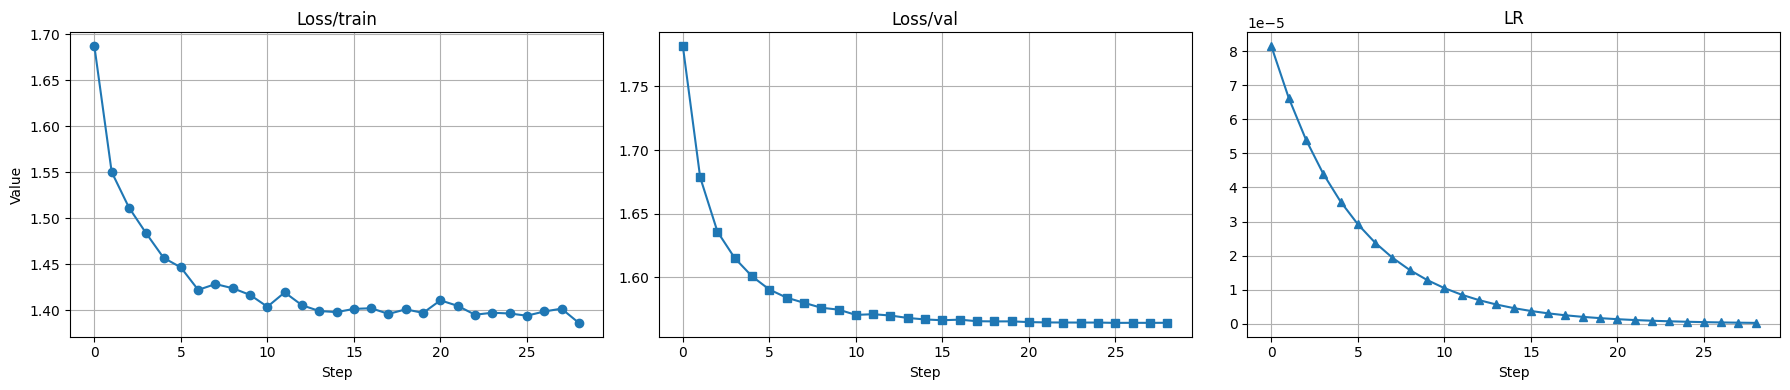

In [21]:
plot_tensorboard_metrics(log_dir="./runs/experiment1")

Métricas obtenidas desde los archivos de TensorBoard utilizado para el monitoreo durante el entrenamiento.

### Quick test 

In [22]:
generate(model, device, "To be", max_new_tokens=100,use_cache=True) 

"To be fair purpose: dear stick i' pray.\n\nPERDITA:\nSt, but prithee, the plot of the poach,\nAnd so night my"

In [24]:
from torchinfo import summary

summary(
    model,
    input_size=(8, config.block_size),
    dtypes=[torch.int64],
    col_names=["input_size", "output_size", "num_params"],
    verbose=0               # 0: tabla, 1: lista de layers, 2: show all
)

W0806 01:26:00.394000 87886 torch/_dynamo/convert_frame.py:964] [12/8] torch._dynamo hit config.recompile_limit (8)
W0806 01:26:00.394000 87886 torch/_dynamo/convert_frame.py:964] [12/8]    function: 'torch_dynamo_resume_in_forward_at_19' (/tmp/ipykernel_87886/2910168612.py:19)
W0806 01:26:00.394000 87886 torch/_dynamo/convert_frame.py:964] [12/8]    last reason: 12/7: ___check_obj_id(self._modules['dropout'], 139772517894240)
W0806 01:26:00.394000 87886 torch/_dynamo/convert_frame.py:964] [12/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0806 01:26:00.394000 87886 torch/_dynamo/convert_frame.py:964] [12/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
OptimizedModule                                    [8, 32]                   [8, 32, 65]               --
├─TinyGPT: 1-1                                     [8, 32]                   [8, 32, 65]               --
│    └─Embedding: 2-1                              [8, 32]                   [8, 32, 128]              8,320
│    └─Embedding: 2-2                              [32]                      [32, 128]                 4,096
│    └─ModuleList: 2-3                             --                        --                        --
│    │    └─Block: 3-1                             [8, 32, 128]              [8, 32, 128]              329,856
│    │    └─Block: 3-2                             [8, 32, 128]              [8, 32, 128]              329,856
│    │    └─Block: 3-3                             [8, 32, 128]              [8, 32, 128]              329,856
│    │    └─Block: 3

# Task I

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [ ]:
@torch.no_grad()
def generateV2(
    model,
    device,
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
)-> Optional[str]:

    model.eval()
    init_len = len(encode(prompt))
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    torch.cuda.synchronize()
    t0 = time.time()
    for n_iters in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        # get logits for last position
        logits = logits[:, -1, :]  # shape [1, V]

        # Greedy if temperature == 0
        if temperature == 0:
            next_token = logits.argmax(dim=-1, keepdim=True)
        else:
            # apply temperature
            logits = logits / temperature
            if top_k > 0:
                k_vals, _ = torch.topk(logits, top_k, dim=-1)
                min_k = k_vals[..., -1, None]
                logits = torch.where(logits < min_k, torch.full_like(logits, -float('Inf')), logits)

            if 0 < top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True, dim=-1)
                sorted_probs = F.softmax(sorted_logits, dim=-1)
                cum_probs = torch.cumsum(sorted_probs, dim=-1)

                # mask out tokens with cumulative prob above top_p
                mask = cum_probs > top_p
                # keep first token above threshold
                mask[..., 1:] = mask[..., :-1].clone()
                mask[..., 0] = False

                sorted_logits = sorted_logits.masked_fill(mask, -float('Inf'))
                # scatter back to original ordering
                logits = torch.full_like(logits, -float('Inf')).scatter(
                    dim=-1, index=sorted_indices, src=sorted_logits
                )

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)
    torch.cuda.synchronize()
    t1 = time.time()
    bs = idx.size(0) 
    tokens = idx.size(1) - init_len
    # display(f"Generatev2 {tokens * bs} tokens in {t1 - t0} seconds")
    return decode(idx[0].tolist()), (tokens * bs) / (t1 - t0)

### Función `generateV2`: Generación de texto con Greedy, Temperatura, Top-K y Top-P

Esta utilidad implementa un bucle de generación de tokens paso a paso, con las siguientes características:

1. **Modo evaluación y preparación**  
   - Se pasa el modelo a `eval()` para desactivar dropout y otros mecanismos de entrenamiento.  
   - Codificamos el `prompt` a IDs y creamos un tensor `idx` de forma `[1, L]` en el dispositivo.

2. **Cache de llaves/valores (KV-cache)**  
   - Si `use_cache=True`, reutilizamos el cache de las capas de atención para acelerar cada paso.  
   - `kv_cache` se inicializa en `None` y se va actualizando con cada `forward`.

3. **Bucle de generación (`max_new_tokens` iteraciones)**  
   - En cada iteración solo enviamos al modelo el último token (`idx[:, -1:]`) si tenemos cache, o toda la ventana de contexto de tamaño `block_size` si no.  
   - El modelo devuelve los `logits` (y opcionalmente el nuevo `kv_cache`).

4. **Selección del siguiente token**  
   - **Greedy** (`temperature=0`): tomamos `argmax(logits)` para máxima probabilidad.  
   - **Temperatura** (`temperature>0`): escalamos los logits por `1/temperature`, afinando o suavizando la distribución.  
   - **Top-K** (`top_k>0`): conservamos solo los `K` tokens más probables y ponemos el resto a \(-\infty\).  
   - **Top-P (nucleus sampling)** (`0<top_p<1`): ordenamos por probabilidad, calculamos la suma acumulada y descartamos todo token más allá del umbral `p`, dejando al menos el primer token.  
   - Después de filtrar con Top-K/Top-P, aplicamos `softmax` y muestreamos con `torch.multinomial()`.

5. **Actualización del índice**  
   - Concatenamos el token elegido al tensor `idx`, ampliando el contexto para la siguiente iteración.

6. **Medición de rendimiento**  
   - Sincronizamos GPU antes y después del bucle (`torch.cuda.synchronize()`) y medimos el tiempo transcurrido.  
   - Calculamos cuántos **tokens nuevos** (batch_size × nuevos tokens) se generaron por segundo:  
     ```python
     tokens   = idx.size(1) - longitud_inicial
     throughput = (batch_size * tokens) / elapsed_time
     ```

7. **Salida**  
   - Devolvemos el texto decodificado (`decode(idx[0])`) y el **throughput** en tokens/segundo para poder comparar la velocidad entre diferentes modelos o configuraciones.

Este enfoque unifica en una única función las estrategias de _greedy search_, _temperatura_, _top-K_ y _nucleus (top-P)_ sampling, junto con el uso opcional de KV-cache para maximizar la velocidad en GPU.


## Compare generate vs generateV2

In [26]:
for i in range(1,3):
    result_1 = generate(model, device, "To be", max_new_tokens=100, use_cache=True)
    result_2, throughput_2 = generateV2(model, device, "To be", max_new_tokens=100, use_cache=True)
    result_3, throughput_3 = generateV2(model, device, "To be", max_new_tokens=100, temperature=0, use_cache=True)
    print("#"*40)
    print(f"Pasada {i}")
    print("-"*40)
    print(result_1)
    print("-"*40)
    print(result_2)
    print("-"*40)
    print(result_3)

########################################
Pasada 1
----------------------------------------
To bent it be!
O many lord of us on Dight!

HERMIONE:
I Fire-changed blood, to have the been guiltile.

G
----------------------------------------
To be day not bloody of my father's company; and, send thy bad?

CAPULET:
What doth you shall do I do bes
----------------------------------------
To be the consent of the prince of the state,
And the state of the state of the state,
And the state of t
########################################
Pasada 2
----------------------------------------
To be no mother, nor proceed: alas, better advices
And the time on their own that; she's
consentence.

GR
----------------------------------------
To be caller to his head of his mine,
Which I did find of holy sea, we was we wont by my sends,
I said as
----------------------------------------
To be the consent of the prince of the state,
And the state of the state of the state,
And the state of t


Se puede observar que con ambos `generate` se producen, en la mayoría de los casos, palabras validas en inglés. En algunas corridas, el texto generado tiene la estructura del corpus, es decir de obra de teatro con dialogos. 

Para el caso del temperatura 0 -> greedy, el texto es determinista y según el entrenamiento se puede estancar en repetir frases o palabras. \

- Referencias para las repeticiones: \
    [CLOSING THE CURIOUS CASE OF NEURAL TEXT DEGENERATION](https://openreview.net/pdf?id=dONpC9GL1o) \
    *"In the extreme case, truncating all but the most likely token results in greedy decoding. Though this
    strategy makes it unlikely to sample a token outside the true support, it often results in degenerative
    patterns like repetitio"*  \
    [Learning to Break the Loop: Analyzing and Mitigating Repetitions for Neural Text Generation](https://arxiv.org/pdf/2206.02369) \
    *"While large-scale neural language models, such as GPT2 and BART, have achieved
    impressive results on various text generation tasks, they tend to get stuck in unde-
    sirable sentence-level loops with maximization-based decoding algorithms (e.g.,
    greedy search)"* \
    [THE CURIOUS CASE OF NEURAL TEXT DeGENERATION](https://arxiv.org/pdf/1904.09751) \
    *"maximization-based
    decoding methods such as beam search lead to degeneration — output text that is
    bland, incoherent, or gets stuck in repetitive loops."*

- Referencia para lo determinista: \
    [On Decoding Strategies for Neural Text Generators](https://arxiv.org/pdf/2203.15721) \
    *"3.1 Deterministic Algorithms
    Greedy Search. One approximation of y∗ is ob-
    tained by greedily choosing the most probable to-
    ken at each decoding step t, i.e., the following re-
    cursion is performed until the EOS symbol is cho-
    sen or some maximum time step T is reached"*

## Task II
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

In [27]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) 

    def forward(self, x) -> torch.Tensor:
        return self.net(x)


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [ ]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape
        E       = self.args.num_experts

        logits = self.gate(x)  # [B,T,E]

        if self.training:
            # ——— SOFT-MIXTURE TRAINING ———
            gate_probs  = F.softmax(logits, dim=-1)                 # [B,T,E]
            expert_outs = torch.stack([e(x) for e in self.experts], dim=2)  # [B,T,E,C]
            out         = torch.einsum('bte, btec->btc', gate_probs, expert_outs)

            # ——— AUXILIARY LOAD-BALANCING LOSS ———
            importance = gate_probs.mean(dim=(0,1))                 # [E]
            load       = (gate_probs>0).float().mean(dim=(0,1))     # [E]
            coef       = getattr(self.args, "load_loss_coef", 1e-2)
            self.aux_loss = coef * E * (importance * load).sum()
            return out

        else:
            # ——— HARD-TOP-1 INFERENCE (AGRUPADO) ———
            idx_flat = logits.argmax(dim=-1).view(-1)                # [B*T]
            x_flat    = x.view(B*T, C)                               # [B*T, C]
            perm      = torch.argsort(idx_flat)                      # [B*T]
            inv_perm  = perm.argsort()                               # [B*T]
            x_sorted  = x_flat[perm]                                 # [B*T, C]
            counts    = torch.bincount(idx_flat[perm], minlength=E)  # [E]
            cuts      = counts.cumsum(0).tolist()                    # [E]

            out_sorted = torch.empty_like(x_sorted)
            start = 0
            for e, end in enumerate(cuts):
                if end > start:
                    y_e = self.experts[e](x_sorted[start:end])      # [N_e, C]
                    out_sorted[start:end] = y_e
                start = end

            out_flat = out_sorted[inv_perm]                        # [B*T, C]
            return out_flat.view(B, T, C)


- Considerando el paper [ST-MOE: DESIGNING STABLE AND TRANSFERABLE SPARSE EXPERT MODELS](https://arxiv.org/pdf/2202.08906) en el apéndice A: TOKEN LOAD BALANCE DESCRIPTION se define la pérdida auxiliar.
- Considerando el paper [A REVIEW OF SPARSE EXPERT MODELS IN DEEP LEARNING](https://arxiv.org/pdf/2209.01667) en la sección 2 SPARSE EXPERT MODELS - 2.1 IN DEEP LEARNING para realizar el top-k de expertos, con k=1 experto.

La capa **Mixture of Experts (MoE)** sustituye la red feed-forward tradicional por un conjunto de **E expertos** y un **módulo gate**. Su método `forward(x)` trabaja en dos modos:

#### 1. Entrenamiento (Soft Mixture)

1. **Cálculo de logits de gating**
   ```python
   logits = gate(x)  # forma [B, T, E]
   ```
2. **Probabilidades de gate**
   ```python
   gate_probs = softmax(logits, dim=-1)  # forma [B, T, E]
   ```
3. **Salida de todos los expertos**
   ```python
   expert_outs = stack([e(x) for e in experts], dim=2)  # forma [B, T, E, C]
   ```
4. **Mezcla ponderada (soft mixture)**
   ```python
   out = einsum('bte, btec -> btc', gate_probs, expert_outs)  # forma [B, T, C]
   ```
5. **Pérdida auxiliar de balanceo de carga**\
   Para evitar que un solo experto acapare los tokens, se añade:
   $$
     L_\mathrm{aux}
     = \lambda \; E \; \sum_{e=1}^E (\mathrm{importance}_e \times \mathrm{load}_e)
   $$
   donde:
   $$
     \mathrm{importance}_e = \frac{1}{B\,T} \sum_{b,t} p_{b,t,e},
     \quad
     \mathrm{load}_e = \frac{1}{B\,T} \sum_{b,t} \mathbf{1}\{p_{b,t,e}>0\}.
   $$
6. **Se registra la pérdida balanceada**\
   ```python
   self.aux_loss = coef * E * (importance * load).sum()
   ```

#### 2. Inferencia (Hard Top-1 Routing)

1. **Cálculo de logits de gating**
   ```python
   logits = gate(x)  # forma [B, T, E]

2. **Selección determinista de experto**
   ```python
   idx_flat = logits.argmax(dim=-1).view(-1)  # [B*T]
   ```
3. **Agrupación de embeddings por experto**
   ```python
   x_flat   = x.view(B*T, C)
   perm     = argsort(idx_flat)
   inv_perm = perm.argsort()
   x_sorted = x_flat[perm]  # [B*T, C]
   ```
4. **Cálculo de cortes**
   ```python
   counts = bincount(idx_flat[perm], minlength=E)  # [E]
   cuts   = counts.cumsum(0).tolist()
   ```
5. **Forward por experto en sub-batch**
   ```python
   out_sorted = empty_like(x_sorted)
   start = 0
   for e, end in enumerate(cuts):
       if end > start:
           out_sorted[start:end] = experts[e](x_sorted[start:end])
       start = end
   ```
6. **Reconstrucción del orden y reshape**
   ```python
   out_flat = out_sorted[inv_perm]  # [B*T, C]
   return out_flat.view(B, T, C)
   ```

In [29]:
class CombinedLoss(nn.Module):
    def __init__(self, base_loss: nn.Module, model: nn.Module):
        super().__init__()
        self.base_loss = base_loss
        self.model = model

    def forward(self, outputs, targets):
        # pérdida estándar (p.ej. CrossEntropy)
        loss = self.base_loss(outputs, targets)
        # sumo todos los aux_loss de las capas MoE
        aux = 0.0
        for layer in self.model.modules():
            if hasattr(layer, "aux_loss"):
                aux = aux + layer.aux_loss
        return loss + aux

Se utiliza la clase `CombinedLoss` para no modificar la función de `Trainer` provista.

In [30]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(  
            experts=[Expert(config) for _ in range(config.moe.num_experts)],
            gate=Gate(config),
            moe_args=config.moe
        )

    def forward(self, x):
        return self.moe(x)

## Adding MoE to Config

In [31]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=1)

Reemplazamos la capa densa con 4 expertos. Se configura para trabaja con 1 experto por token procesado.

# Training TinyGPT-MoE


In [32]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)

In [33]:
model_moe

OptimizedModule(
  (_orig_mod): TinyGPT(
    (token_emb): Embedding(65, 128)
    (pos_emb): Embedding(32, 128)
    (blocks): ModuleList(
      (0-3): 4 x Block(
        (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): MultiHeadAttention(
          (heads): ModuleList(
            (0-7): 8 x AttentionHead(
              (key_query_value): Linear(in_features=128, out_features=48, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): MoEFFN(
          (moe): MoELayer(
            (experts): ModuleList(
              (0-3): 4 x Expert(
                (net): Sequential(
                  (0): Linear(in_features=128, out_features=512, bias=True)
                  (1): ReLU()
                  (2): Linear(in_feature

In [34]:
optimizer = AdamW(model_moe.parameters(), lr=1e-4)
# scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
scheduler = StepLR(optimizer, step_size=steps_per_epoch//4, gamma=0.95)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 30

In [35]:
combined_loss = CombinedLoss(base_loss=loss_fn, model=model_moe)
# Trainer instance
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=combined_loss,  #loss_fn
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints/moe",
    save_every_n=500
)
# Training
es = EarlyStopping(patience=3)
for epoch in range(epochs): 
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    val_loss       = trainer.eval_model()

    writer_moe.add_scalar("Loss/train", avg_train_loss, epoch)
    writer_moe.add_scalar("Loss/val",   val_loss,       epoch)

    current_lr = optimizer.param_groups[0]["lr"]
    writer_moe.add_scalar("LR", current_lr, epoch)

    print(f"Epoch {epoch+1} — train_loss: {avg_train_loss:.4f}, val_loss: {val_loss:.4f}, lr: {current_lr:.2e}")

    if es(model_moe, val_loss):
        print(f"Early stopping with patience {es.status}")
        break

writer_moe.close()
print("Training complete.")

  0%|          | 0/3921 [00:00<?, ?it/s]

/home/pablo/IA/NLP2-TP1/wsl-venv/lib/python3.12/site-packages/torch/_inductor/lowering.py:7007: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


  0%|          | 0/435 [00:00<?, ?it/s]

W0806 01:28:15.337000 87886 torch/fx/experimental/symbolic_shapes.py:6679] [19/0] failed during evaluate_expr(u0 > 0, hint=None, size_oblivious=False, forcing_spec=False
E0806 01:28:15.339000 87886 torch/fx/experimental/recording.py:299] [19/0] failed while running evaluate_expr(*(u0 > 0, None, False, False), **{})


Epoch 1 — train_loss: 1.8115, val_loss: 2.0309, lr: 8.15e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 2 — train_loss: 1.6828, val_loss: 1.9101, lr: 6.63e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 3 — train_loss: 1.6233, val_loss: 1.8511, lr: 5.40e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 4 — train_loss: 1.5953, val_loss: 1.8215, lr: 4.40e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 5 — train_loss: 1.5814, val_loss: 1.8061, lr: 3.58e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 6 — train_loss: 1.5668, val_loss: 1.7950, lr: 2.92e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 7 — train_loss: 1.5506, val_loss: 1.7885, lr: 2.38e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 8 — train_loss: 1.5458, val_loss: 1.7834, lr: 1.94e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 9 — train_loss: 1.5421, val_loss: 1.7805, lr: 1.58e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 10 — train_loss: 1.5369, val_loss: 1.7811, lr: 1.29e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 11 — train_loss: 1.5298, val_loss: 1.7767, lr: 1.05e-05


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 12 — train_loss: 1.5254, val_loss: 1.7754, lr: 8.53e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 13 — train_loss: 1.5263, val_loss: 1.7744, lr: 6.94e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 14 — train_loss: 1.5111, val_loss: 1.7733, lr: 5.66e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 15 — train_loss: 1.5226, val_loss: 1.7721, lr: 4.61e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 16 — train_loss: 1.5185, val_loss: 1.7719, lr: 3.75e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 17 — train_loss: 1.5146, val_loss: 1.7710, lr: 3.06e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 18 — train_loss: 1.5150, val_loss: 1.7713, lr: 2.49e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 19 — train_loss: 1.5059, val_loss: 1.7709, lr: 2.03e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 20 — train_loss: 1.5164, val_loss: 1.7709, lr: 1.65e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 21 — train_loss: 1.5151, val_loss: 1.7708, lr: 1.35e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 22 — train_loss: 1.5213, val_loss: 1.7706, lr: 1.10e-06


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 23 — train_loss: 1.5201, val_loss: 1.7704, lr: 8.92e-07


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 24 — train_loss: 1.5007, val_loss: 1.7701, lr: 7.27e-07


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 25 — train_loss: 1.5168, val_loss: 1.7703, lr: 5.92e-07


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 26 — train_loss: 1.5087, val_loss: 1.7702, lr: 4.82e-07


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 27 — train_loss: 1.5130, val_loss: 1.7699, lr: 3.93e-07


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 28 — train_loss: 1.5143, val_loss: 1.7701, lr: 3.20e-07


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 29 — train_loss: 1.5125, val_loss: 1.7699, lr: 2.61e-07


  0%|          | 0/3921 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

Epoch 30 — train_loss: 1.5097, val_loss: 1.7700, lr: 2.12e-07
Training complete.


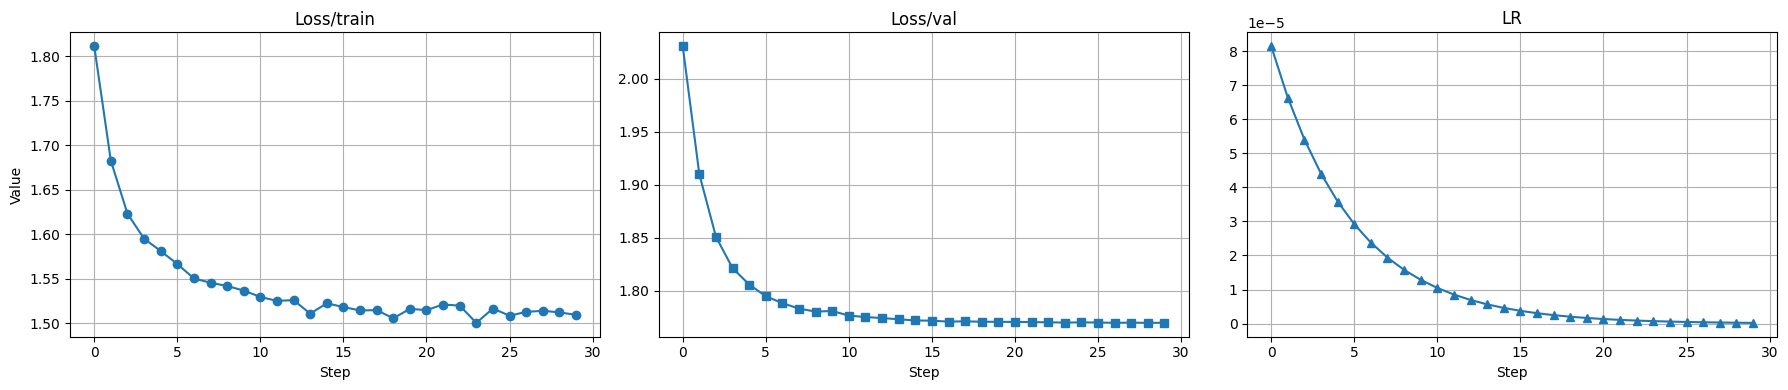

In [36]:
plot_tensorboard_metrics(log_dir="./runs/experiment2")

Métricas obtenidas desde los archivos de TensorBoard utilizado para el monitoreo durante el entrenamiento.

In [37]:
for i in range(1,3):
    result_1 = generate(model_moe, device, "To be", max_new_tokens=100, use_cache=True)
    result_2, _ = generateV2(model_moe, device,"To be", max_new_tokens=100, use_cache=True)
    result_3, _ = generateV2(model_moe, device, "To be", max_new_tokens=100, temperature=0, use_cache=True)
    print("#"*40)
    print(f"Pasada {i}")
    print("-"*40)
    print(result_1)
    print("-"*40)
    print(result_2)
    print("-"*40)
    print(result_3)

########################################
Pasada 1
----------------------------------------
To be death inquired yeher likeous forward sun downrow.

DUKE VINCENTIO:
Go ever his soldier and King Lew
----------------------------------------
To be die themselves, and all things to them,
And as we are that revenged to your brother's person:
He wa
----------------------------------------
To be so much a son of the prince of the sea,
And they shall be so much son and his hours shall be so fai
########################################
Pasada 2
----------------------------------------
To be leven tale of man, with breathed,
Which hath dismissy suits of it? Claudio time, let undo entired.

----------------------------------------
To be marriage in the world have an enemy we of more.

KING RICHARD III:
Northright that she doth me to m
----------------------------------------
To be so much a son of the prince of the sea,
And they shall be so much son and his hours shall be so fai


En este caso, el texto se ve similar al modelo denso, quizas la diferencia mas llamativa es que el texto generado con temperatura 0 tiene una mejor estructura que en el modelo anterior.

In [38]:
from torchinfo import summary

summary(
    model_moe,
    input_size=(8, config.block_size),
    dtypes=[torch.int64],
    col_names=["input_size", "output_size", "num_params"],
    verbose=0               # 0: tabla, 1: lista de layers, 2: show all
)

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
OptimizedModule                                    [8, 32]                   [8, 32, 65]               --
├─TinyGPT: 1-1                                     [8, 32]                   [8, 32, 65]               --
│    └─Embedding: 2-1                              [8, 32]                   [8, 32, 128]              8,320
│    └─Embedding: 2-2                              [32]                      [32, 128]                 4,096
│    └─ModuleList: 2-3                             --                        --                        --
│    │    └─Block: 3-1                             [8, 32, 128]              [8, 32, 128]              593,924
│    │    └─Block: 3-2                             [8, 32, 128]              [8, 32, 128]              593,924
│    │    └─Block: 3-3                             [8, 32, 128]              [8, 32, 128]              593,924
│    │    └─Block: 3

## Visualizing Attention

As we know, a GPT has the task to complete text, let's see the attention maps generated by a pretrained model

In [39]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()


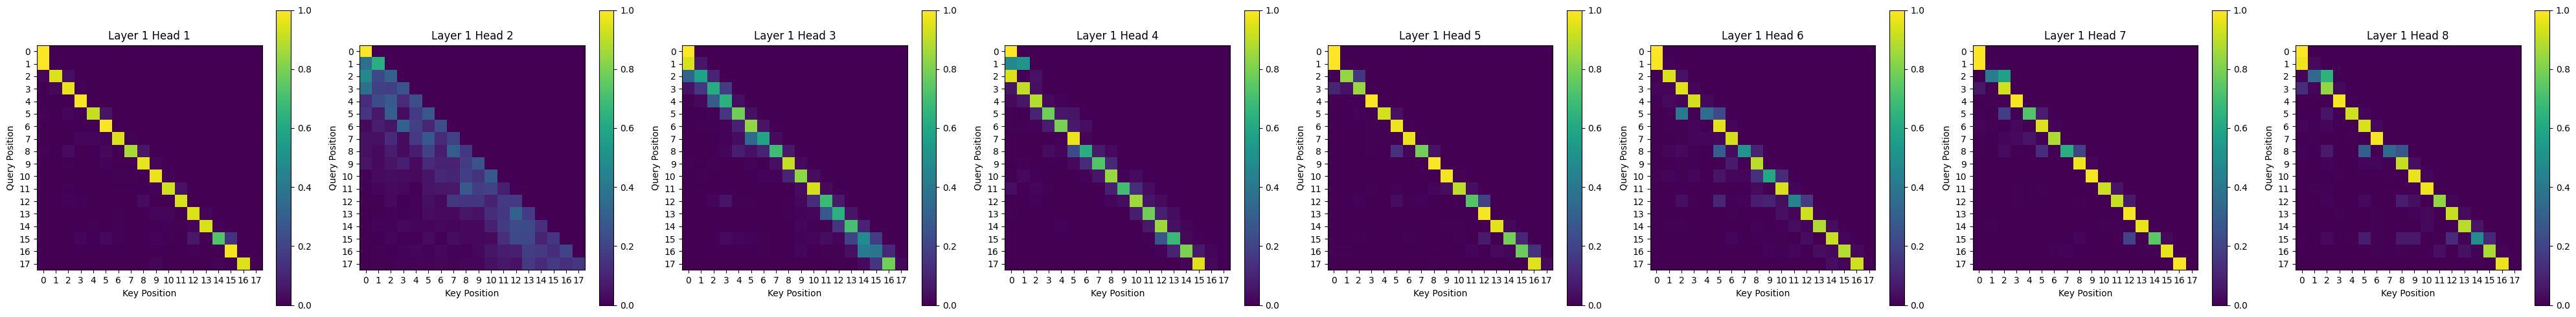

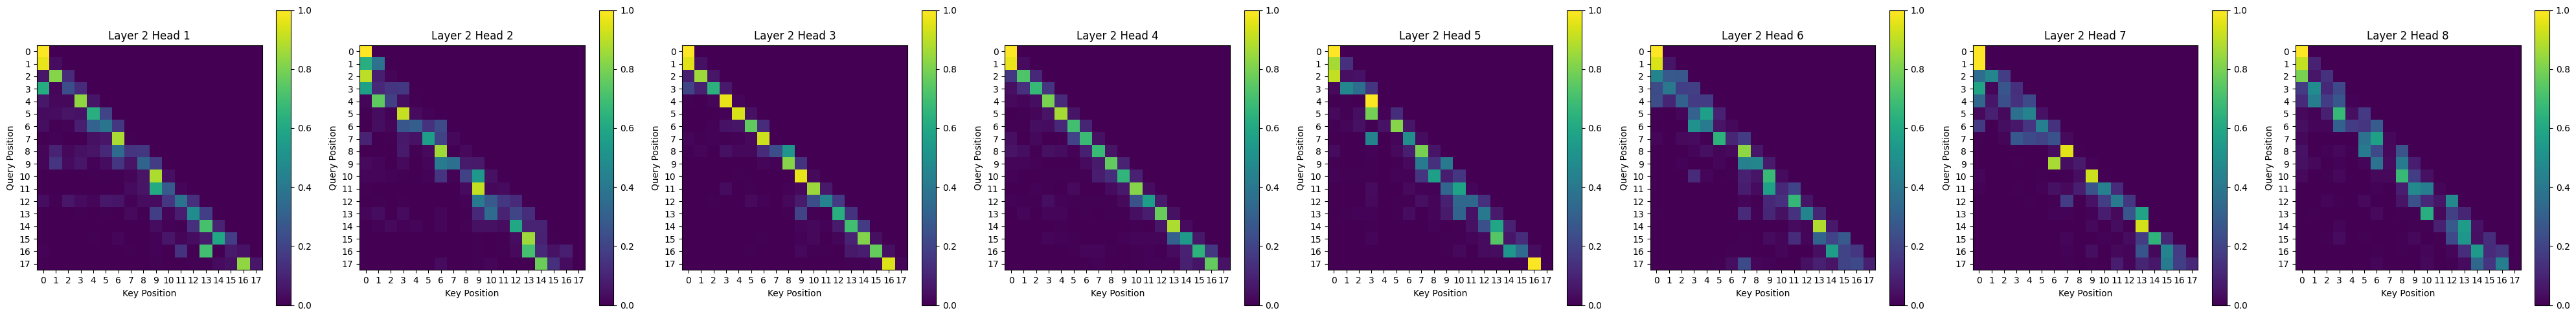

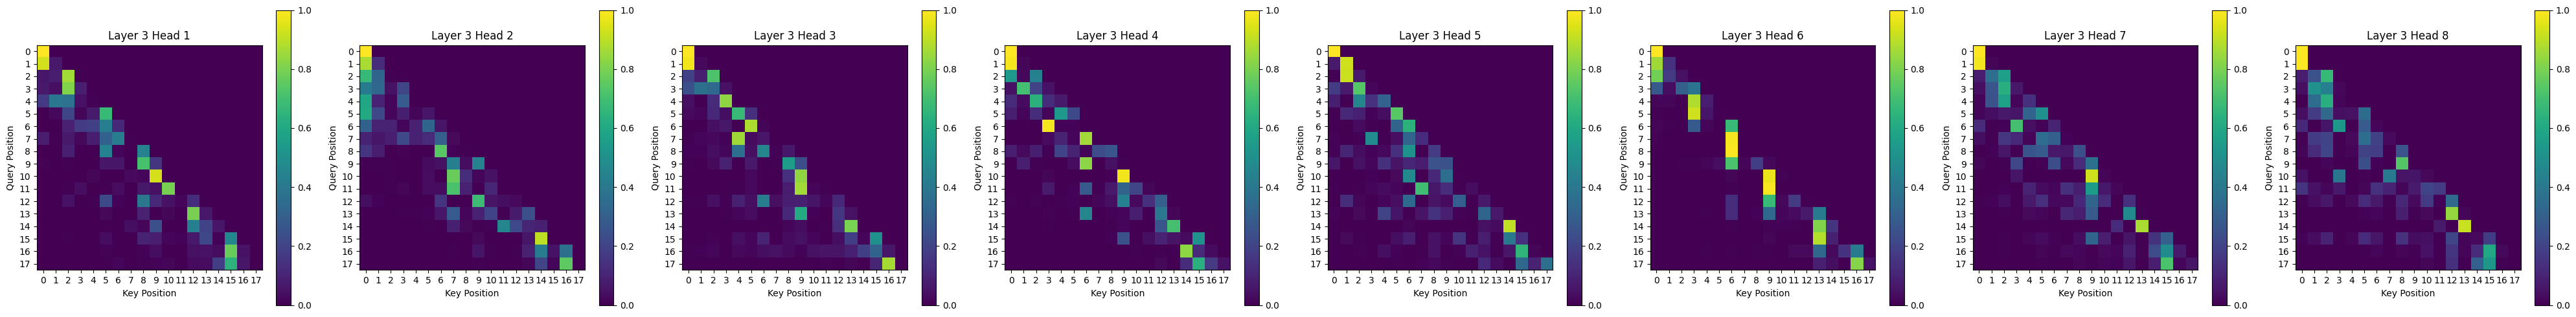

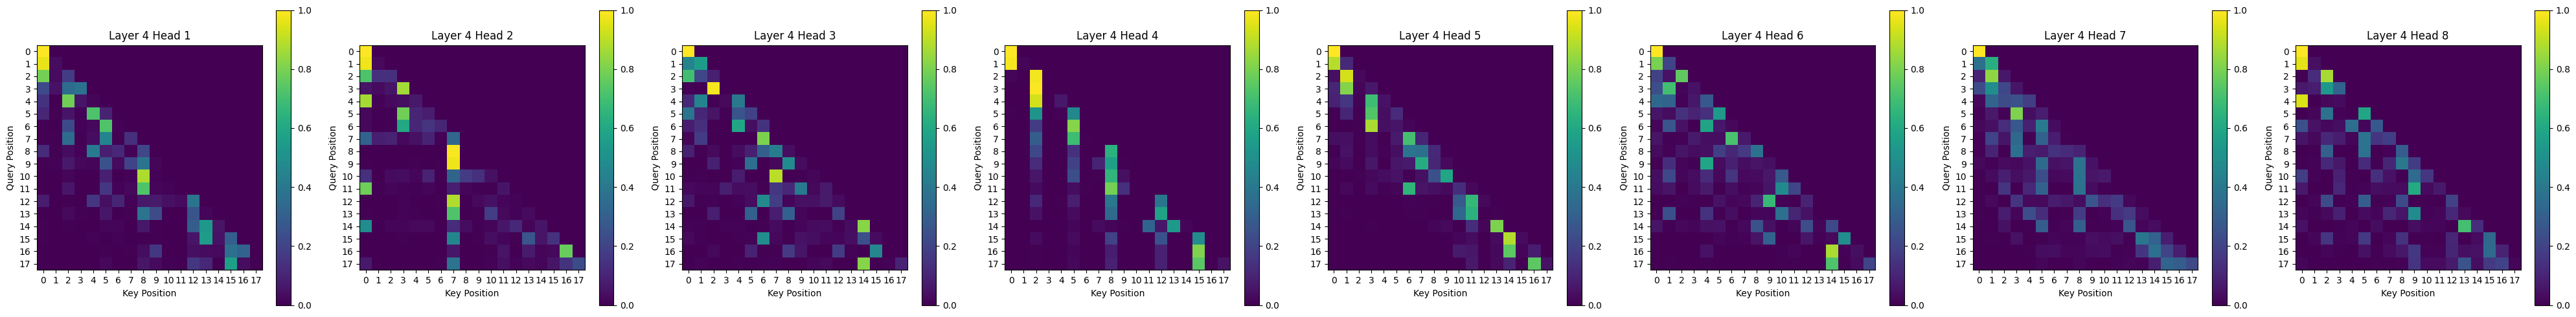

In [40]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

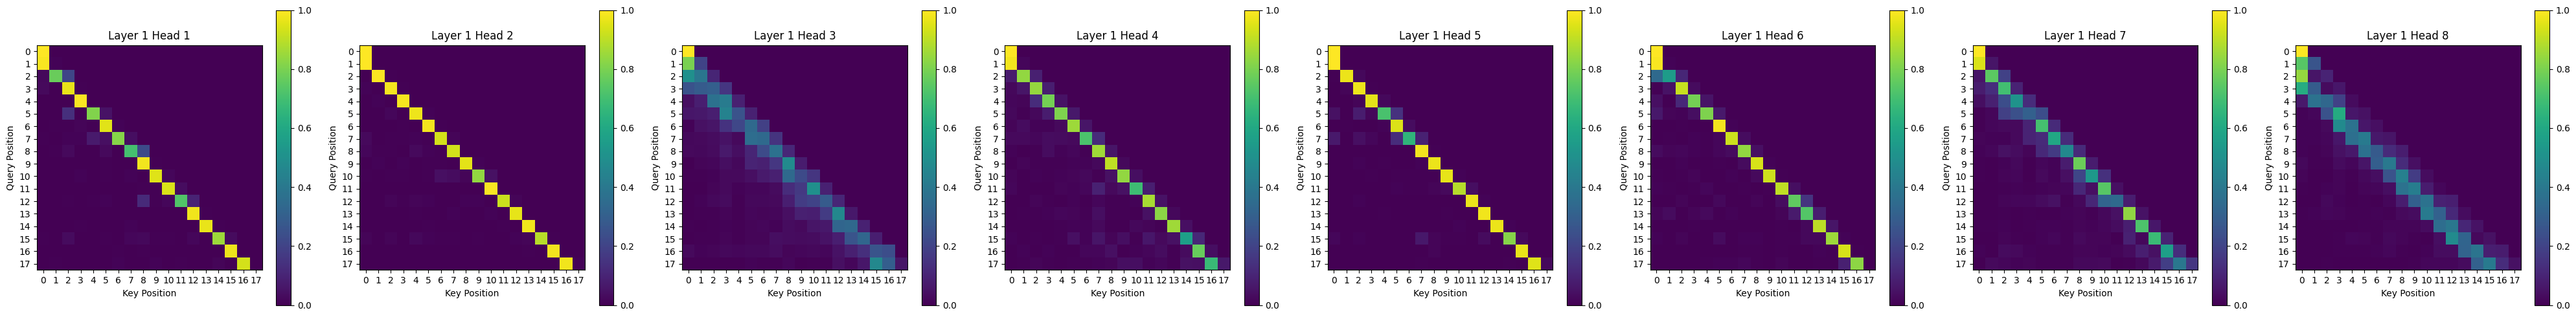

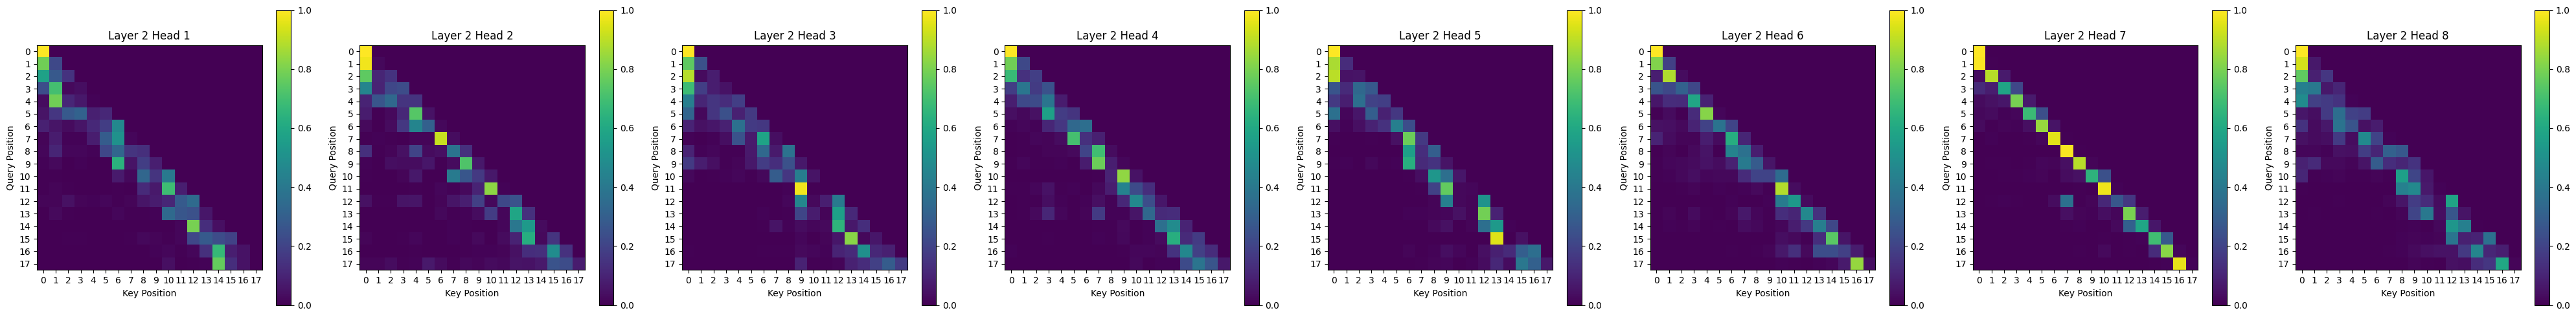

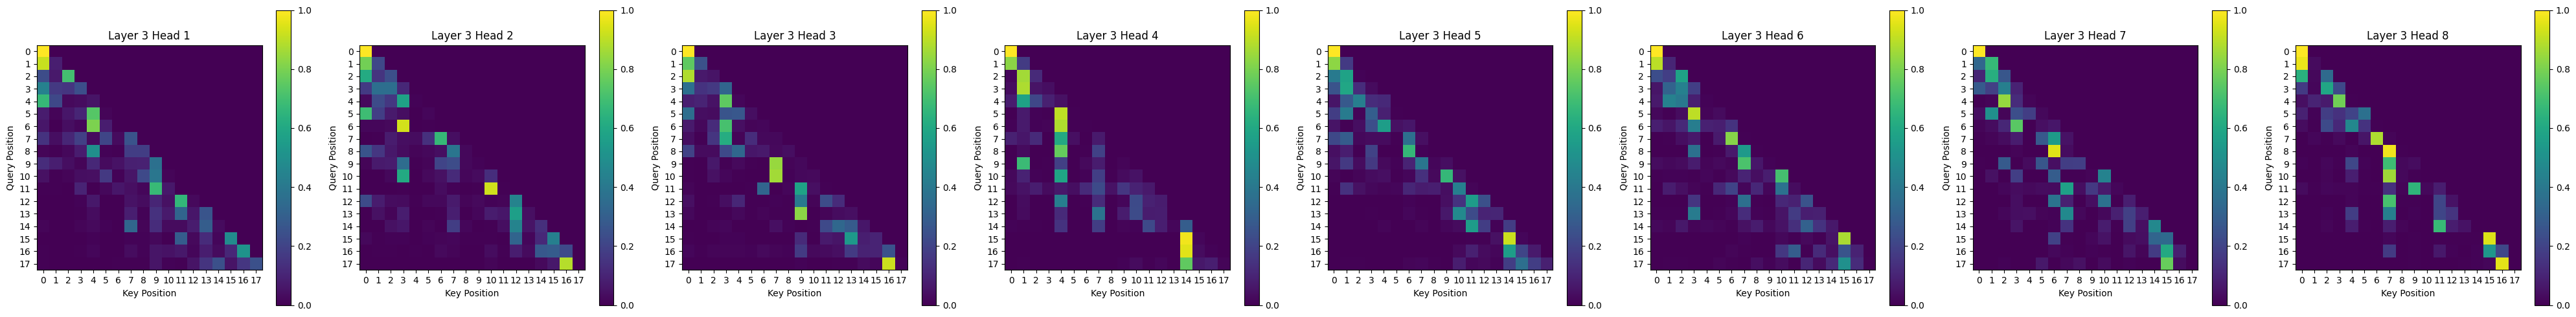

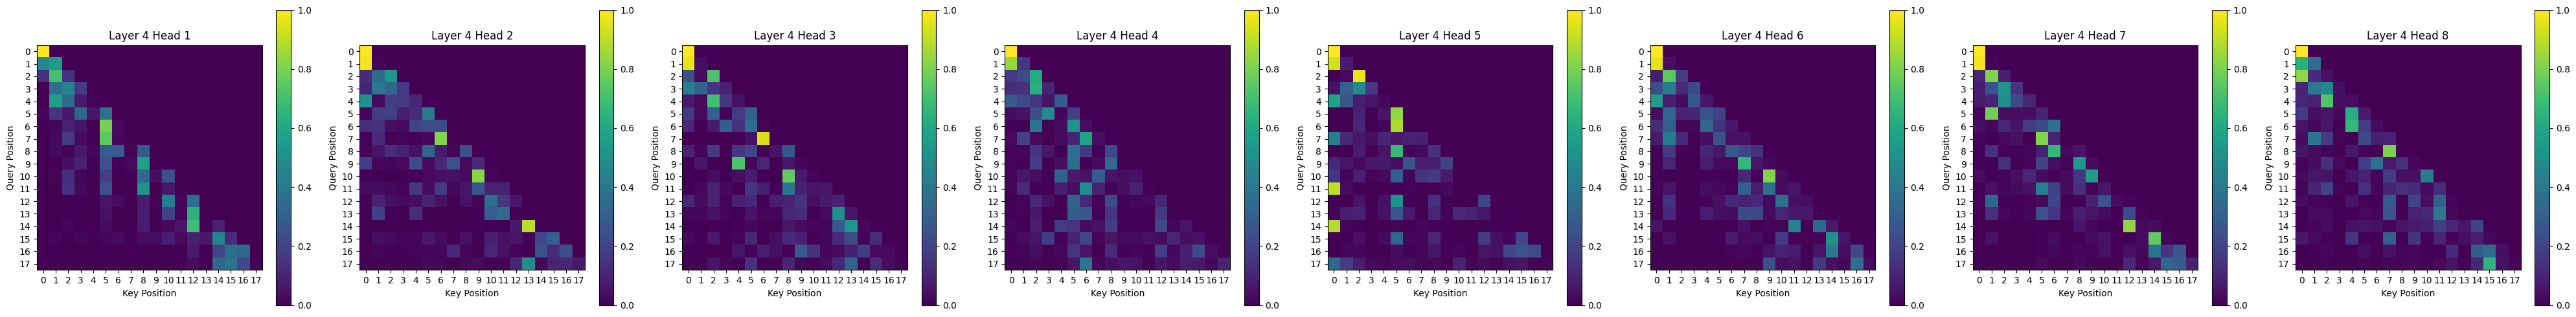

In [41]:
visualize_attention(model_moe, prompt)

# Conclusions

In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

dense_params = count_parameters(model)
moe_params   = count_parameters(model_moe)
print(f"Parámetros Dense: {dense_params:,}")
print(f"Parámetros MoE:   {moe_params:,}")

Parámetros Dense: 1,340,416
Parámetros MoE:   2,396,688


In [43]:
result, throughput = generateV2(model, device,"To be or not", max_new_tokens=2000, use_cache=True, temperature=0.7, top_p=0.95)
result_moe, throughput_moe = generateV2(model_moe, device,"To be or not", max_new_tokens=2000, use_cache=True, temperature=0.7, top_p=0.95)

print(f"#### Dense #### \n{result[:12]}...")
print(f"#### MoE #### \n{result_moe[:12]}...")
print("-"*40)
print(f"Dense throughput: {throughput} tokens/sec")
print(f"MoE throughput: {throughput_moe} tokens/sec")


#### Dense #### 
To be or not...
#### MoE #### 
To be or not...
----------------------------------------
Dense throughput: 168.42593896728934 tokens/sec
MoE throughput: 113.78043216068951 tokens/sec


In [44]:
print(f"El modelo que utiliza MoE es {((throughput_moe/throughput)-1)*100:.2f}% más rápido")

El modelo que utiliza MoE es -32.44% más rápido


In [45]:
@torch.no_grad()
def compute_perplexity(model, data_loader, loss_fn, device):
    """
    Computes perplexity of `model` on the dataset in `data_loader`.
    - loss_fn debe tener reduction='sum' para acumular log-prob.
    - data_loader debe devolver (inputs, targets) donde targets es el next-token.
    """
    model.eval().to(device)
    total_loss = 0.0   # suma de -log p()
    total_tokens = 0   # total de tokens evaluados

    for inputs, targets in data_loader:
        inputs  = inputs.to(device)
        targets = targets.to(device)
        # outputs: [B, T, vocab_size]
        outputs = model(inputs)
        B, T, V = outputs.shape

        # reshape para calcular CrossEntropy sobre cada token
        logits = outputs.view(B*T, V)
        targs  = targets.view(B*T)

        # loss_fn con reduction='sum'
        loss   = loss_fn(logits, targs)

        total_loss  += loss.item()
        total_tokens += B * T

    avg_nll = total_loss / total_tokens       # negative log-likelihood per token
    ppl     = math.exp(avg_nll)
    return ppl


Calculamos la perplejidad con validación en los modelos ya pre entrenados como: \

$\mathrm{PPL} = \exp\bigl(-\tfrac{1}{N}\sum_{i=1}^N \log p(w_i \mid w_{<i})\bigr)$

In [52]:
# prepara un loss que sume los log-probs
base_loss = nn.CrossEntropyLoss(reduction='sum')

dense_ppl = compute_perplexity(
    model    = model,
    data_loader = val_loader,
    loss_fn  = base_loss,
    device   = device
)

moe_ppl   = compute_perplexity(
    model       = model_moe,
    data_loader = val_loader,
    loss_fn     = base_loss,
    device      = device
)

print(f"Dense model    → Perplexity: {dense_ppl:.2f}")
print(f"MoE   model    → Perplexity: {moe_ppl:.2f}")

Dense model    → Perplexity: 4.78
MoE   model    → Perplexity: 5.00


In [47]:
device_cpu = torch.device("cpu")
dense_cpu   = model.cpu()
moe_cpu     = model_moe.cpu()

In [48]:
result_moe, throughput_moe = generateV2(moe_cpu, device_cpu,"To be or not", max_new_tokens=2000, use_cache=True, temperature=0.7, top_p=0.95)
result, throughput = generateV2(dense_cpu, device_cpu,"To be or not", max_new_tokens=2000, use_cache=True, temperature=0.7, top_p=0.95)

print(f"#### Dense #### \n{result[:12]}...")
print(f"#### MoE #### \n{result_moe[:12]}...")
print("-"*40)
print(f"Dense throughput: {throughput} tokens/sec")
print(f"MoE throughput: {throughput_moe} tokens/sec")

#### Dense #### 
To be or not...
#### MoE #### 
To be or not...
----------------------------------------
Dense throughput: 294.1893468529983 tokens/sec
MoE throughput: 204.851753074727 tokens/sec


In [49]:
print(f"El modelo que utiliza MoE es {((throughput_moe/throughput)-1)*100:.2f}% más rápido")

El modelo que utiliza MoE es -30.37% más rápido


De el articulo de HuggingFace sobre [MoE](https://huggingface.co/blog/moe) podemos ver que lo que se espera de un modelo denso vs disperso es:
- Se preentrenan mucho más rápido que los modelos densos.
- Tienen una inferencia más rápida en comparación con un modelo con el mismo número de parámetros.
- Requieren una alta VRAM, ya que todos los expertos se cargan en memoria.
- El ajuste fino presenta muchos desafíos, pero los trabajos recientes con el ajuste de instrucciones MoE son prometedores.

Para el caso de este modelo, el cual es muy pequeño, la unica diferencia observable es que MoE si se lleva muchos mas parámetros. Se compara el modelo denso con una FFN:

```python
self.net = nn.Sequential(
    nn.Linear(config.n_embd, 8 * config.n_embd),        
    nn.ReLU(),
    nn.Linear(8 * config.n_embd, config.n_embd),
    nn.Dropout(config.dropout),
)
```
VS 4 expertos de:
```python
self.net = nn.Sequential(
    nn.Linear(config.n_embd, 4 * config.n_embd),
    nn.ReLU(),
    nn.Linear(4 * config.n_embd, config.n_embd),
    nn.Dropout(config.dropout)
)
```
En total, el modelo con capa densa tiene 1.340.416 parámetros, mientras que el modelo MoE (disperso) suma 2.396.688. \
Cada experto posee la mitad de los parámetros de la capa densa; por eso, con 4 expertos el total en memoria es mayor (4 × ½ = 2×). Esto no es literalmente el producto dado que se comparten capas entre ambos, como las cabezas de atención. \
En inferencia, con enrutamiento top-1 y sin contar el gate, sólo se activa un experto, de modo que los parámetros efectivos son la mitad que en la densa (con top-2 serían ~los mismos).

En la medición del throughput, podemos ver como el modelo denso es mas rápido. Esto se lo podemos adjudicar a la falta de optimización en el paralelismo de la GPU en el caso del MoE, ya que se estan usando las estructuras de pytorch más básicas. Además, al ser modelos muy pequeños, posiblemente el overhead del gate se hace notar frente al trabajo que hacen las FFN en si.\
Si pasamos los modelos a CPU, esta diferencia se reduce. Como el modelo es de muy pocos parametros no se logran apreciar las mejoras de MoE en la inferencia.

En cuanto a la perplejidad, al menos para validación, el modelo denso es levemente más seguro en predecir el siguiente token que el MoE.

----------